In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [92]:
class Warehouse():
    def __init__(self):
        self.shops = []
        self.storage = np.zeros(4)
        self.log = pd.DataFrame(columns=["Day","storeId","itemAge","sumItem","overBuy"])
        self.dayCount = 1

    def predict_order(self):
        #TODO: Implement prediction
        # max(0,shop_avg_sum - sum_of_all_storage)
        # if theres more storage then expected we don't need to order
        return max(0,sum([shop.avg for shop in self.shops])-sum([sum(shop.storage) for shop in self.shops]))

    def addShop(self,shop):
        self.storage += shop.avg
        self.shops.append(shop)
        
    def one_day(self):
        
        #summ orders from Stores
        order_sum = sum([x.ordered_amount for x in self.shops])
        #distribution
        for shop in self.shops:
            if order_sum == 0:
                shop.one_day(round(self.storage[0]/len(self.shops),0))
            else:
                shop.one_day(round(self.storage[0]*(shop.ordered_amount/order_sum),0))
            
        #new Warehouse storage is sum of Store averages
        self.storage = np.roll(self.storage,-1)
        
        self.storage[3] = self.predict_order()
        #LOGGING
        for shop in self.shops:
            new_row = {
                "Day" : self.dayCount, 
                "storeId" : shop.id, 
                "itemAge" : 0 if shop.storage[-1] == 0 else len(shop.storage), #storage is never empty due to negative index errors
                "sumItem" : sum(shop.storage),
                "overBuy" : -shop.overbuy}
            self.log.loc[len(self.log.index)] = new_row
        self.dayCount += 1

class Shop():
    def __init__(self,avg,std, id):
        self.id = id
        self.avg = avg
        self.std = std
        self.overbuy = 0
        self.ordered_amount = self.avg
        self.storage = [0]
        
    def get_sold_amount(self):
        return round(np.random.normal(self.avg, self.std, 1)[0],0)
    
    def update_storage(self):
        #get daily demand amount from distribution
        bought_amount = self.get_sold_amount()
        #rolling subtraction of demand from storage
        for index in range(len(self.storage)):
            bought_amount -= self.storage[index]
            if(bought_amount >= 0):
                self.storage[index] = 0
            else:
                self.storage[index] = (-1)*bought_amount
                bought_amount = 0
                break
            
        return bought_amount

    def one_day(self,received):
        #place items from warehouse to most fresh place
        self.storage.insert(0,received)
        
        #process supply and demand
        self.overbuy = self.update_storage()
        
        #calculate order for next day
        self.ordered_amount = self.avg-sum(self.storage)
        if(self.ordered_amount<0):
            self.ordered_amount = 0
        while(self.storage[-1] == 0 and len(self.storage) > 1):
            self.storage.pop()
        

In [93]:
w = Warehouse()
w.addShop(Shop(10,5,1))

In [94]:
for _ in range(300):
    w.one_day()

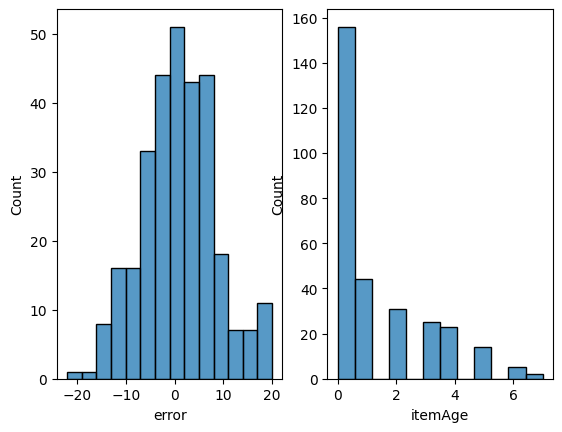

In [95]:
fig, axes = plt.subplots(1,2)
w.log["error"] = w.log.apply(lambda x: x.overBuy+x.sumItem,axis=1)
sns.histplot(data=w.log,x="error",ax=axes[0])
sns.histplot(data=w.log,x="itemAge",ax=axes[1])
plt.show()

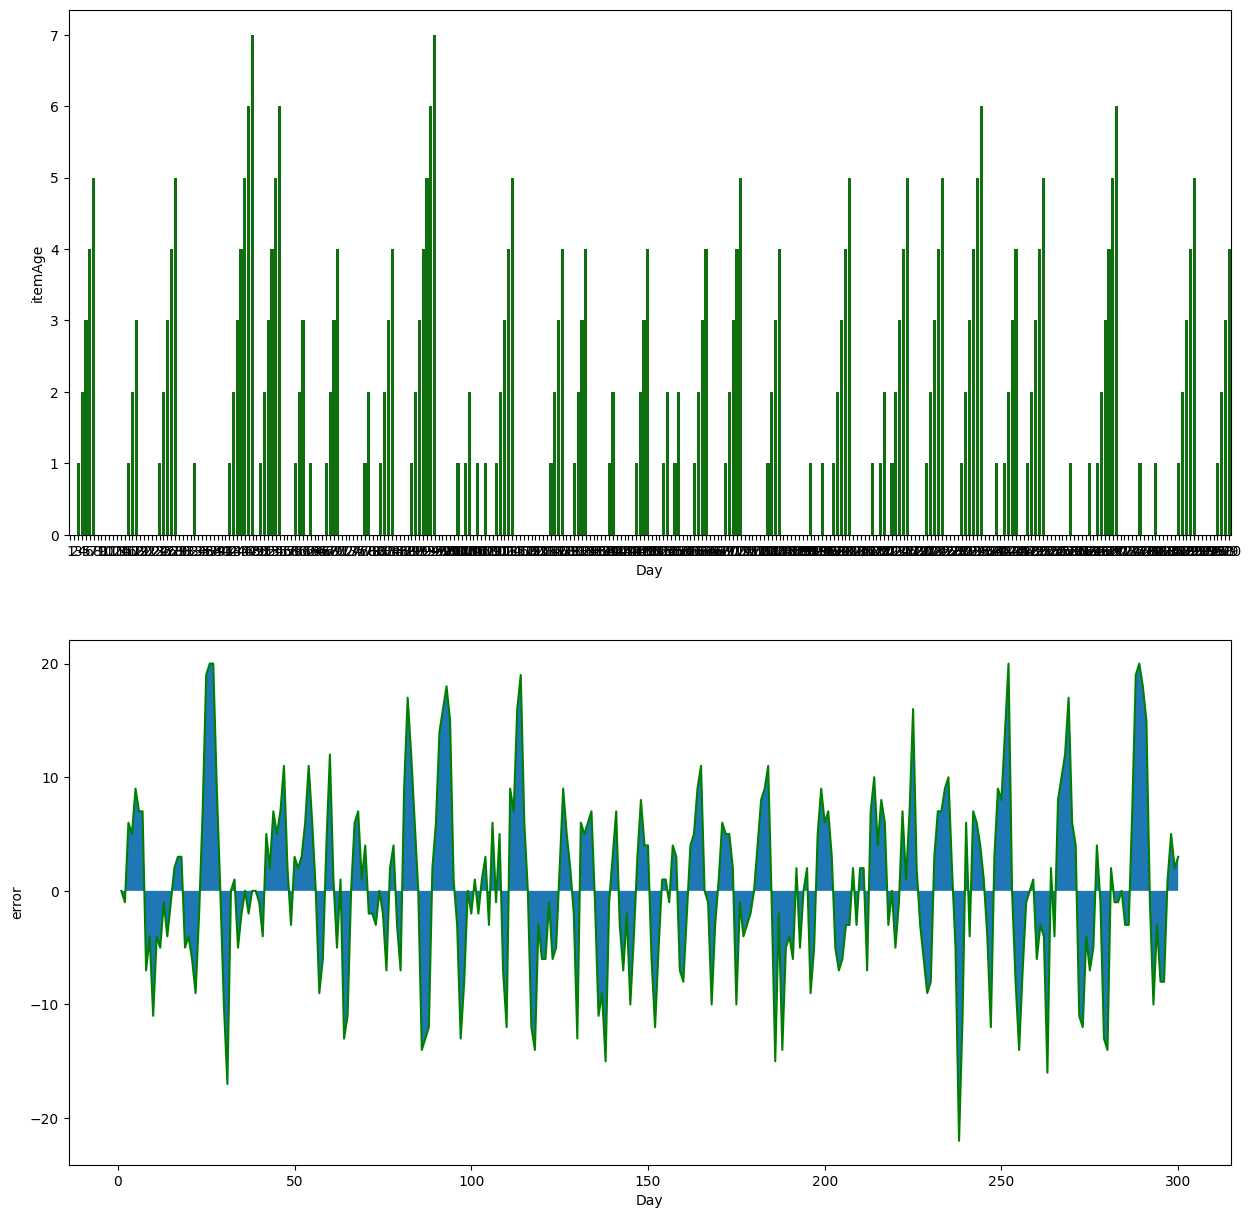

In [96]:
fig, axes = plt.subplots(2)
fig.set_figheight(15)
fig.set_figwidth(15)
sns.barplot(data=w.log,x="Day",y="itemAge",color="green", ax= axes[0])
#sns.barplot(data=w.log,x="Day",y="overBuy",color="red", ax= axes[1])
#sns.barplot(data=w.log,x ="Day", y="sumItem",color="green", ax= axes[1])
w.log["error"] = w.log["overBuy"] + w.log["sumItem"]
sns.lineplot(data=w.log,x ="Day", y="error",color="green", ax= axes[1])
plt.fill_between(w.log["Day"],w.log["error"],interpolate=True)

plt.show()